In [2]:
import numpy as np 
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
import glob
from timeit import default_timer as timer
import sys
from numba import njit
from scipy.stats import gaussian_kde,iqr

mpl.rcParams['figure.dpi'] = 300

#### MSD Libs #######
@njit
def self_nofft(r):
    """Compute the self MSD from a single particle trajectory using a double loop."""
    N = r.shape[0]
    lags = np.arange(N)
    msd = np.zeros(lags.size)    
    # compute sepeartely for each lag
    for i, lag in enumerate(lags):
        if lag == 0:
            continue
        dr = r[:-lag] - r[lag:]
        dr2 = np.square(dr).sum(axis=1)
        msd[i] = dr2.mean()
    return msd

@njit
def dist_nofft(r1, r2):
    """Compute the distinct particles MSD from a single particle trajectory
using a double loop.
    """
    N = r1.shape[0]
    lags = np.arange(N)
    msd = np.zeros(lags.size)    
    # compute sepeartely for each lag
    for i, lag in enumerate(lags):
        if lag == 0:
            r = r1 - r2
            continue
        dr = r[:-lag] - r[lag:]
        dr2 = np.square(dr).sum(axis=1)
        msd[i] = dr2.mean()
    return msd

def _autocorr_fft(x):
    """Compute the autocorrelation of 1d signal using FFT."""
    N = x.shape[0]
    # 2*N because of zero-padding to compute non-cyclic correlation
    f = np.fft.fft(x, n=2*N)
    power_spectrum = f * f.conjugate()
    result = np.fft.ifft(power_spectrum)
    # the autocorrelation in the usual convention B
    result = (result[:N]).real
    return result

@njit 
def _msd_fft_compute_s1(r):
    """Compute the non-FFT part of the MSD in the FFT method."""
    N = r.shape[0]
    # Compute the squared distances
    D = np.square(r).sum(axis=1)
    # Apply the recursive algorithm
    s1 = np.zeros(N)
    s1[0] = 2*D.sum()
    for n in range(1, N):
        s1[n] = s1[n-1] - D[n-1] - D[N-n]
    return s1

def self_fft(r):
    """Compute the self MSD from a single particle trajectory using FFT.

    Based on the algorithm outlined in Section 4.2 of the following paper:
    https://doi.org/10.1051/sfn/201112010
    """
    N = r.shape[0]
    # Compute the non-FFT part
    s1 = _msd_fft_compute_s1(r)
    # Compute the FFT-part separately over each position component
    s2 = np.zeros_like(s1)
    for i in range(r.shape[1]):
        s2 += _autocorr_fft(r[:, i])
    return (s1 - 2*s2) / np.arange(N, 0, -1)

def dist_fft(r1, r2):
    """Compute the dist MSD from a single particle trajectory using FFT."""
    return self_fft(r1 - r2)

def read_h (files):
    #### Read Header File, getting number of particles, box size, timestep #######
    f=open(files[0],'r')
    trash = f.readline()
    trash = f.readline()
    elems = str.split(trash.strip()," ") 
    #  print (str.isdigit(elems[0]))
    if str.isdigit(elems[0])==True:
        #print ("yay")
        time1 = float(elems[0])/1
        trash = f.readline() 
        trash = f.readline()
        elems = str.split(trash," ") 
        npart = int(elems[0]);
        trash = f.readline()
        trash = f.readline()
        trash = f.readline()
        trash = f.readline()
        elems = str.split(trash," ")
        mybox = float(elems[1])-float(elems[0])
        trash = f.readline()
    #### Read Header File of second file, getting number of particles, box size, timestep #######
    f=open(files[1],'r')
    trash = f.readline()
    trash = f.readline()
    elems = str.split(trash.strip()," ") 
    #  print (str.isdigit(elems[0]))
    if str.isdigit(elems[0])==True:
        #print ("yay")
        time2 = float(elems[0])/1
        trash = f.readline() 
        trash = f.readline()
        elems = str.split(trash," ") 
        npart = int(elems[0]);
        trash = f.readline()
        trash = f.readline()
        trash = f.readline()
        trash = f.readline()
        elems = str.split(trash," ")
        mybox = float(elems[1])-float(elems[0])
        trash = f.readline()
    framestep=int(time2-time1)
    return framestep, npart, mybox


def CoM (out,npart): #### Calculates CoM of particles takes as input unwrapped data, box and #of particles ############
    comx=np.sum(out[:,1])
    comy=np.sum(out[:,2])
    comz=np.sum(out[:,3])
    com = np.array([comx,comy,comz])/(npart)
    return com

@njit(fastmath=True,)      
def compute_rg(data,com):
    temp=0
    for i in range (data[:,0].size):
        xx=np.abs(data[i,1]-com[0])
        yy=np.abs(data[i,2]-com[1])
        zz=np.abs(data[i,3]-com[2])
        temp=temp+xx*2+yy**2+zz**2
    temp=temp/data[:,0].size
    #print(temp)
    return temp

# pos = np.zeros((len(traj), Number_of_particles, 3)) #in this array you load the particle positions. traj is the trajectory, i.e. it has len = number of snapshots
# time = np.zeros(len(traj))
# pos -= pos.mean(axis=1).reshape(-1, 1, 3)# Subtracts the global mean - !important because Langevin can cause it's radom diffusion - unphysical!
# msds = np.zeros((N, len(traj)))
# for i in trange(pos.shape[1]):
#     msds[i] = self_fft(pos[:,i])
# plt.loglog(time[1:], msds.mean(axis=0)[1:])




In [34]:
wdir=glob.glob("data_equil*")
print(wdir)

['data_equil', 'data_equilg13_rg_SMALL_96.dat', 'data_equil_1', 'data_equil_2', 'data_equil_2g13_rg_SMALL_96.dat']


In [18]:
#### Build pos array #######
wdir="data_equil/"
wfile="test_pos*"
filename=wdir+wfile
files=glob.glob(filename)
files.sort(key=os.path.getmtime)
framestep,npart,box=read_h(files)
pos=np.zeros((len(files),npart,3))

count=0
start=timer()
for i in files:  
    start_n=timer()
    data=np.genfromtxt(i,skip_header=9)
    data=data[np.argsort(data[:,0])]
    temp=data[:,2:5]+data[:,5:8]*box
    pos[count]=temp
    count+=1
    end=timer()
    tpf=end-start_n
    files_left=len(files)-count
    t_left=tpf*files_left
    g="%.2f percent in %.3f seconds ETA:%.3f seconds "%(100*count/len(files),end-start,t_left)
    sys.stdout.write("\r" + str(g))
    sys.stdout.flush()
mean_pos=pos.mean(axis=1).reshape(-1, 1, 3)
pos-=mean_pos
#msds = np.zeros((npart, len(files)))

100.00 percent in 2017.912 seconds ETA:0.000 seconds    

In [19]:
#### Calculate MSDs #######
time = np.zeros(len(files))
count=0
for tt in range(len(files)):
    time[tt]=count*framestep*0.01
    count+=1

    
msds = np.zeros((npart, len(files)))
for i in range(pos.shape[1]):
    start=timer()
    msds[i] = self_fft(pos[:,i])
    end=timer()
    g="Particle %d Wall time %.4f seconds"%(i, end-start)
    sys.stdout.write("\r" + str(g))
    sys.stdout.flush()



Particle 9983 Wall time 0.0978 seconds

TypeError: can only concatenate list (not "str") to list

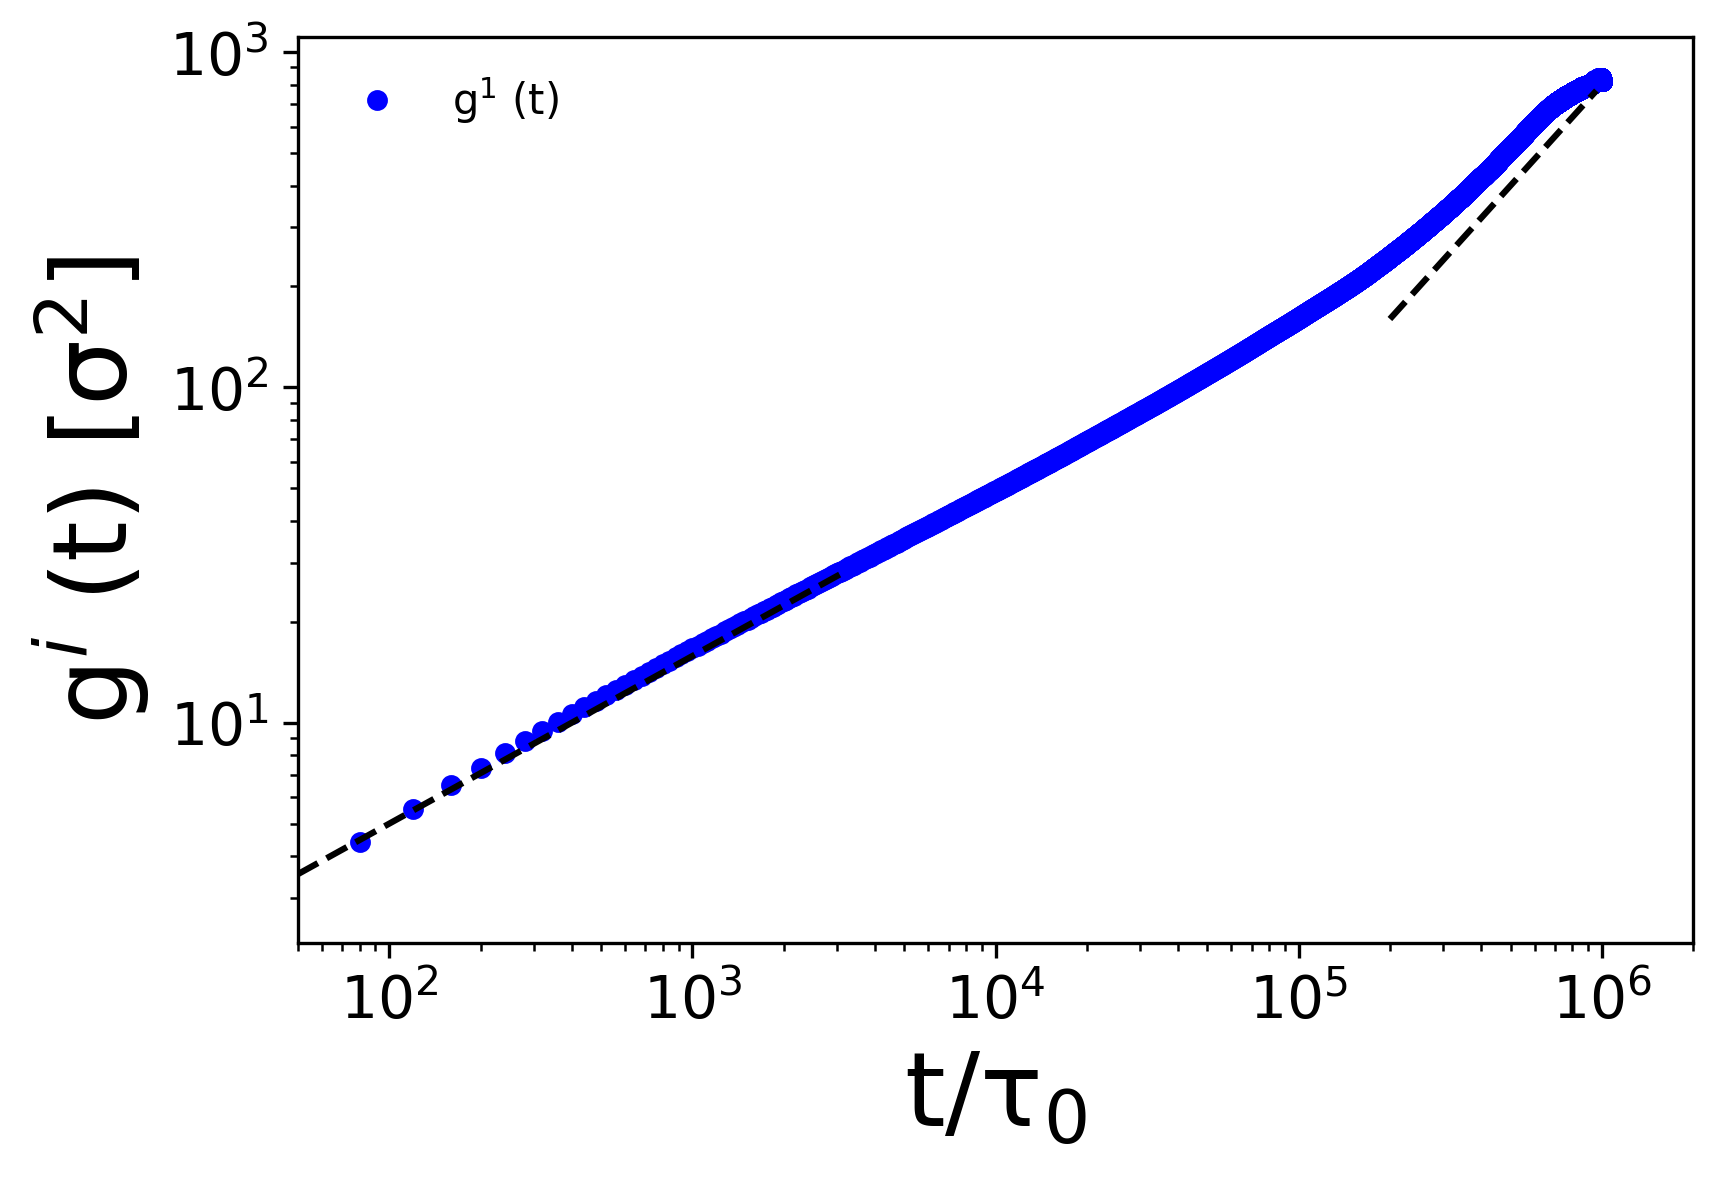

In [42]:
#data_in=np.genfromtxt("data_equil_2g13_rg_SMALL_96.dat")
#data_lammps=np.genfromtxt("./data_equil/rg2.txt",skip_header=1)
plt.loglog(time[1:], msds.mean(axis=0)[1:],'bo',label='g$^1$ (t)',markersize=4)
#plt.loglog(time[1:], msds_nofft.mean(axis=0)[1:],'r-',label='Double Loop Iurri')
#plt.loglog(data_in[:,0]*0.01,data_in[:,1],'ks',label='Double Loop Me',markersize=4)
#plt.loglog(data_lammps[:,0],data_lammps[:,1],'g--',label='LAMMPS')
plt.legend(frameon=False)
plt.ylabel("g${^i}$ (t) [σ${^2}$]",fontsize=25)
plt.xlabel("t/τ$_0$",fontsize=25)
plt.xticks(fontsize=14);plt.yticks(fontsize=14)
plt.xlim(50,2e6)
#plt.ylim(3,1000)
#plt.text(2E2,1.3,'t$^{3/4}$',fontsize=15)
#plt.text(2E2,3,'t$^{1/2}$',fontsize=15)
#plt.text(3E5,180,'t',fontsize=15)
#plt.plot(time[1000:10000],0.2*msds.mean(axis=0)[1000:10000]**(3/4),'k--')
plt.plot(time[5000:24000],0.0008*time[5000:24000]**1,'k--')
plt.plot(time[1:80],0.5*time[1:80]**(1/2),'k--')
#plt.savefig('msds.png',dpi=300,bbox_inches='tight')
np.savetxt(wdir+'msd.dat',(np.stack((time[1:],msds.mean(axis=0)[1:]),axis=-1)))

array([[4.00000000e+01, 2.92303173e+00],
       [8.00000000e+01, 4.39794075e+00],
       [1.20000000e+02, 5.54320141e+00],
       ...,
       [9.99920000e+05, 8.19151498e+02],
       [9.99960000e+05, 8.19646263e+02],
       [1.00000000e+06, 8.20648676e+02]])